In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os
import os.path
import numpy as np
import torchvision.transforms as transforms
import pickle
from torch.utils.data import Dataset, DataLoader
from skimage import io, color
from tqdm import tqdm

import copy
import random
import time
import pdb
import os, sys

import numpy as np
import torch
import torch.utils.model_zoo as model_zoo
from torch import nn, optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url

In [2]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, tanh=False):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.tanh = tanh

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        if self.tanh:
            out = nn.Tanh()(out)
        else:
            out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, tanh=False):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1], tanh=tanh)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
        #                                dilate=replace_stride_with_dilation[2])
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False, tanh=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks-1):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        layers.append(block(self.inplanes, planes, groups=self.groups,
                            base_width=self.base_width, dilation=self.dilation,
                            norm_layer=norm_layer, tanh=tanh))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         featmap = x
#         x = self.layer4(x)
#         x = self.avgpool(x)
        
        return x

    def forward(self, x):
        return self._forward_impl(x)

    
class Discriminator(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, tanh=False):
        super(Discriminator, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 256
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_cls = nn.Linear(512 * block.expansion, 10)
        self.fc_adv = nn.Linear(512 * block.expansion, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False, tanh=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks-1):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        layers.append(block(self.inplanes, planes, groups=self.groups,
                            base_width=self.base_width, dilation=self.dilation,
                            norm_layer=norm_layer, tanh=tanh))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.layer4(x)
        feats = self.avgpool(x)
        feats = torch.flatten(feats, 1)
        logits_cls = self.fc_cls(feats)
        logits_adv = self.fc_adv(feats)
        return feats, logits_cls, logits_adv

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, layer_4, fixed, tanh=False):
    model = ResNet(block, layers, tanh=tanh)
    if pretrained:
        model_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
#         model_dict = model_zoo.load_url("https://download.pytorch.org/models/resnet18-5c106cde.pth")
        def remove_layer4(model_dict):
            layer4_params = []
            for k, v in model_dict.items():
                if k.startswith('layer4'):
                    layer4_params.append(k)
            for p in layer4_params:
                model_dict.pop(p, None)
            return model_dict

        model_dict = remove_layer4(model_dict)
        model_dict.pop('fc.weight', None)
        model_dict.pop('fc.bias', None)
        model.load_state_dict(model_dict)
        # TODO: layer4 param not used
        # if layer_4:
        #     for name,child in model.named_children():
        #         if name != 'layer4':
        #             for param in child.parameters():
        #                 param.requires_grad = False
        if fixed:
            for name,child in model.named_children():
                for param in child.parameters():
                    param.requires_grad = False
#         model.eval()
#         model.load_state_dict(state_dict)
    return model
    
class Generator(nn.Module):
    def __init__(self, width = 12, deconv = False):
        super(Generator, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        nfms = width
        if deconv:
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, nfms*8, 4, stride=2, padding=1),  # [batch, width*8, 2, 2]
                nn.LeakyReLU(0.2, inplace=True),
                nn.ConvTranspose2d(nfms*8, 256, 4, stride=2, padding=1),  # [batch, width*4, 4, 4]
                nn.LeakyReLU(0.2, inplace=True),
                nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),  # [batch, width*2, 8, 8]
                nn.LeakyReLU(0.2, inplace=True),
                nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),  # [batch, width*1, 16, 16]
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0),# [batch, width*1, 14, 14]
            )
        else:
            self.decoder = nn.Sequential(
                nn.Upsample(size=(2,2), mode='nearest'),
                nn.Conv2d(512, nfms*8, kernel_size=2, stride=1, padding=1), 
                nn.LeakyReLU(0.2, inplace=True),
                # state size. 
                nn.Upsample(size=(4,4), mode='nearest'),
                nn.Conv2d(nfms*8, 256, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf*8) x 4 x 4
                nn.Upsample(size=(8,8), mode='nearest'),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                # state size. (ngf*4) x 8 x 8
                nn.Upsample(size=(14,14), mode='nearest'),
                nn.Conv2d( 256, 256, kernel_size=3, stride=1, padding=1),
            )
        self.output_act = nn.Tanh()

    def forward(self, x):
        decoded = self.decoder(x)
        decoded = self.output_act(decoded)
        return decoded
    
def resnet18(pretrained=False, progress=True, layer_4=False, fixed=False, tanh=False):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    if pretrained:
        print("Loaded pretrained resnet model")
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress, layer_4, fixed, tanh=tanh)

def discriminator():
    return Discriminator(BasicBlock, [2,2,2,2], tanh=False)

def generator():
    return Generator(width=32, deconv=True)


    

In [3]:
class CIFAR10(Dataset):
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False):

        super(CIFAR10, self).__init__()
        self.root = root
        self.train = train  # training set or test set

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []
        self.transform = transform
        self.target_transform = transforms.Compose(
            [transforms.ToTensor(), ])
        
        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
     
        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}
    
    def _ret_data(self):
        return self.data, self.targets

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img_, target = self.data[index], self.targets[index]
        img_224 = Image.fromarray(img_)
        img_32 = Image.fromarray(img_)
        img_224 = img_224.resize((224,224), resample=0)
        
        if self.transform is not None:
            img_224 = self.transform(img_224)
            img_32 = self.target_transform(img_32)
#             target = self.target_transform(target)
            
        return img_224, img_32, target


    def __len__(self):
        return len(self.data)




class CIFAR100(CIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.

    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])
trainset = CIFAR10(root='../data', train=True,
                   download=True, transform=transform)
testset = CIFAR10(root='../data', train=False,
                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


torch.Size([100, 3, 224, 224]) torch.Size([100, 3, 32, 32])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7])


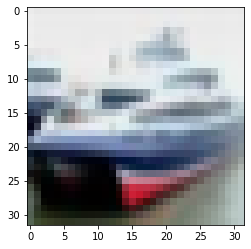

In [5]:
for img_224, img_32, target in test_loader:
    print(img_224.shape, img_32.shape)
    print(target)

    img = img_32[1].numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(img)
    break

In [6]:
model = resnet18(pretrained=True, progress=True, layer_4=True, tanh=True).to(0)
model.eval()
print(model)

Loaded pretrained resnet model
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [7]:
train_featmaps = []
test_featmaps = []
for i, (inputs, inputs_32, targets) in tqdm(enumerate(train_loader)):
    inputs, inputs_32, targets = inputs.to(0), inputs_32.to(0), targets.to(0)
    featmaps = model(inputs).detach().cpu().numpy()
    train_featmaps.extend(featmaps)
   
for i, (inputs, inputs_32, targets) in tqdm(enumerate(test_loader)):
    inputs, inputs_32, targets = inputs.to(0), inputs_32.to(0), targets.to(0)
    featmaps = model(inputs).detach().cpu().numpy()
    test_featmaps.extend(featmaps)
    
train_featmaps = np.array(train_featmaps)
test_featmaps = np.array(test_featmaps)

500it [01:31,  5.44it/s]
100it [00:19,  5.06it/s]


MemoryError: Unable to allocate 9.35 GiB for an array with shape (50000, 256, 14, 14) and data type float32

In [8]:
np.save("train_featmaps.npy", train_featmaps)
np.save("test_featmaps.npy", test_featmaps)

MemoryError: Unable to allocate 9.35 GiB for an array with shape (50000, 256, 14, 14) and data type float32